In [140]:
import pennylane as qml
from pennylane import numpy as np
import qiskit
from qiskit import QuantumCircuit
sys.path.append('..')
from q_alchemy.qiskit import QAlchemyInitialize

os.environ["Q_ALCHEMY_API_KEY"] = "n6I5ypSXJeb8E1mlX71gAJ1v9RCKSb52"


In [141]:
def my_quantum_function(x, y):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(y, wires=1)
    return qml.expval(qml.PauliZ(1))

dev_unique_wires = qml.device('default.qubit', wires=['aux', 'q1', 'q2'])
circuit = qml.QNode(my_quantum_function, dev_unique_wires)
print(qml.draw(circuit)(np.pi/4, 0.7))

0: ──RZ(0.79)─╭●───────────┤     
1: ───────────╰X──RY(0.70)─┤  <Z>


In [142]:
qc = QuantumCircuit(2,2)
qc.rz(np.pi/4, 0)
qc.cx(0, 1)
qc.ry(0.7, 1)
qc.draw()

┌─────────┐                
q_0: ┤ Rz(π/4) ├──■─────────────
     └─────────┘┌─┴─┐┌─────────┐
q_1: ───────────┤ X ├┤ Ry(0.7) ├
                └───┘└─────────┘
c: 2/═══════════════════════════

In [143]:
inst = qc.data
print(len(inst))
print(inst[0][0])



3
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483])


In [144]:
import re

def extract_gates(input_string):
    name_match = re.findall(r'name=\'(\w+)\'', input_string)
    params_match = re.findall(r'params=\[(.*?)\]', input_string)
    
    return name_match, params_match

    
def extract_qubits(input_string):
    qubit_matches = re.findall(r'\),\s(\d)', input_string)
    if qubit_matches:
        return qubit_matches
    else:
        return None

In [145]:
def circuit_to_list(inst):
    n = len(inst)
    gates = []
    params = []
    qubits = []
    for i in range(n):
        gate, param = extract_gates(str(inst[i][0]))
        qubit = extract_qubits(str(inst[i][1]))
        gates.append(gate[0])
        params.append(param[0])
        qubits.append(qubit)
    return gates, params, qubits
        

In [146]:
gates, params, qubits = circuit_to_list(inst)

print(gates)
print(params)
print(qubits)

['rz', 'cx', 'ry']
['0.7853981633974483', '', '0.7']
[['0'], ['0', '1'], ['1']]


In [147]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)

def list_to_pennylane(gates, params, qubits):
    print(gates)
    for i in range(len(gates)):
        if gates[i] == 'rz':
            qml.RZ(float(params[i]), wires=float(qubits[i][0]))
        elif gates[i] == 'cx':
            qml.CNOT(wires=[float(qubits[i][0]), float(qubits[i][1])])
        elif gates[i] == 'ry':
            qml.RY(float(params[i]), wires=float(qubits[i][0]))
    return qml.expval(qml.PauliZ(1))

In [148]:
dev_unique_wires = qml.device('default.qubit', wires=['aux', 'q1', 'q2'])
circuit = qml.QNode(list_to_pennylane, dev_unique_wires)


In [149]:

gates, params, qubits = circuit_to_list(inst)
drawer = qml.draw(circuit)
print(drawer(gates, params, qubits))

['rz', 'cx', 'ry']
0: ──RZ(0.79)─╭●───────────┤     
1: ───────────╰X──RY(0.70)─┤  <Z>


In [155]:
import tensorflow as tf
import numpy as np
def load_minist01():
    classes = [0, 1]
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
    
    x_train_filter_01 = np.where((y_train == classes[0]) | (y_train == classes[1]))
    x_test_filter_01 = np.where((y_test == classes[0]) | (y_test == classes[1]))

    X_train, X_test = x_train[x_train_filter_01], x_test[x_test_filter_01]
    Y_train, Y_test = y_train[x_train_filter_01], y_test[x_test_filter_01]
    
    Y_train = [1 if y == classes[0] else -1 for y in Y_train]
    Y_test = [1 if y == classes[0] else -1 for y in Y_test]
    
    X_train = tf.image.resize(X_train[:], (256, 1)).numpy()
    X_test = tf.image.resize(X_test[:], (256, 1)).numpy()
    X_train, X_test = tf.squeeze(X_train).numpy(), tf.squeeze(X_test).numpy()
    
    X_train_norms, X_test_norms = np.linalg.norm(X_train, axis=1), np.linalg.norm(X_test, axis=1)
    X_train_norms, X_test_norms = X_train_norms[:, np.newaxis], X_test_norms[:, np.newaxis]
    
    X_train, X_test = X_train/X_train_norms, X_test/X_test_norms
    
    return X_train, X_test, Y_train, Y_test

In [193]:
from qiskit import transpile

def preparation_circuit(X):
    sp_org = QAlchemyInitialize(X, opt_params={'max_fidelity_loss':0.0})
    qc_final = QuantumCircuit(sp_org.definition.num_qubits, name="preparation")
    qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc

In [194]:
X_train, X_test, y_train, y_test = load_minist01()

qc = preparation_circuit(X_train[0])

/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [197]:
dev = qml.device("default.qubit", wires=8)

@qml.qnode(dev)

def list_to_pennylane(gates, params, qubits):
    for i in range(len(gates)):
        if gates[i] == 'rz':
            qml.RZ(float(params[i]), wires=(-int(qubits[i][0])+7))
        elif gates[i] == 'cx':
            qml.CNOT(wires=[7-int(qubits[i][0]), 7-int(qubits[i][1])])
        elif gates[i] == 'ry':
            qml.RY(float(params[i]), wires=(7-int(qubits[i][0])))
        elif gates[i] == 'rx':
            qml.RX(float(params[i]), wires=(7-int(qubits[i][0])))
    return qml.state()

In [198]:
gates, params, qubits = circuit_to_list(qc.data)
pennylane_circuit = list_to_pennylane(gates, params, qubits)
print(pennylane_circuit)

[-1.32742634e-15-3.70852054e-16j  1.35317531e-16-2.16453671e-17j
 -2.75618055e-02+1.10729030e-01j -3.26222871e-02+1.31059419e-01j
  7.58003415e-05-3.04526434e-04j  2.01417659e-15+4.56449115e-16j
 -1.29040556e-02+5.18417983e-02j -6.06300913e-16+4.76264603e-17j
  2.89494837e-16-2.53376535e-17j  1.45473056e-15+4.45212268e-16j
 -3.39381385e-02+1.36345827e-01j -1.94510835e-02+7.81443589e-02j
 -2.41866782e-03+9.71695207e-03j -9.63141547e-05+3.86940274e-04j
 -2.54944173e-03+1.02423338e-02j  1.04789469e-15+1.19496573e-16j
 -1.57951037e-15-4.06675782e-16j -2.36225464e-16-1.24114525e-16j
 -3.44050453e-02+1.38221616e-01j -3.19928524e-02+1.28530677e-01j
 -1.11702727e-04+4.48763585e-04j  1.51961776e-15+3.43475248e-16j
 -6.52854457e-03+2.62283039e-02j -3.22161627e-17+1.75067763e-16j
  3.79940297e-16-6.21285027e-17j  1.45386395e-15+4.98836696e-16j
 -2.77959397e-02+1.11669660e-01j -2.15814637e-03+8.67031209e-03j
 -1.43532285e-02+5.76638232e-02j -1.94106052e-02+7.79817381e-02j
 -5.69168888e-04+2.286625

In [199]:
gates, params, qubits = circuit_to_list(qc.data)
dev_unique_wires = qml.device('default.qubit', wires=['aux', 'q1', 'q2'])
circuit = qml.QNode(list_to_pennylane, dev_unique_wires)
drawer = qml.draw(circuit)
print(drawer(gates, params, qubits))

0: ──RY(0.01)──╭●─────────RY(-0.57)──RZ(-3.14)─╭●──RZ(0.75)──╭●──────────────────────────────────
1: ────────────╰X─────────RY(-0.11)──RZ(-3.14)─│─────────────│─────────────────────────────────╭●
2: ──RZ(-1.39)──RY(0.72)──RZ(-0.38)────────────│─────────────│─────────────────────────────────│─
3: ──RZ(-1.55)──RY(1.66)──RZ(0.52)─────────────│─────────────╰X──RZ(-2.09)──RY(1.59)──RZ(1.66)─│─
4: ────────────────────────────────────────────╰X──RZ(-1.95)───────────────────────────────────│─
5: ────────────────────────────────────────────────────────────────────────────────────────────╰X
6: ──RZ(-1.57)──RY(1.61)──RZ(-0.03)──────────────────────────────────────────────────────────────
7: ──RZ(-1.55)──RY(1.41)──RZ(-0.29)──────────────────────────────────────────────────────────────

───────────────────────────────────────────────────────╭●──────────────────────────────────────
───RZ(-1.04)─╭●────────────────────────────────────────│───────────────────────────────────────
─────────────│─────────

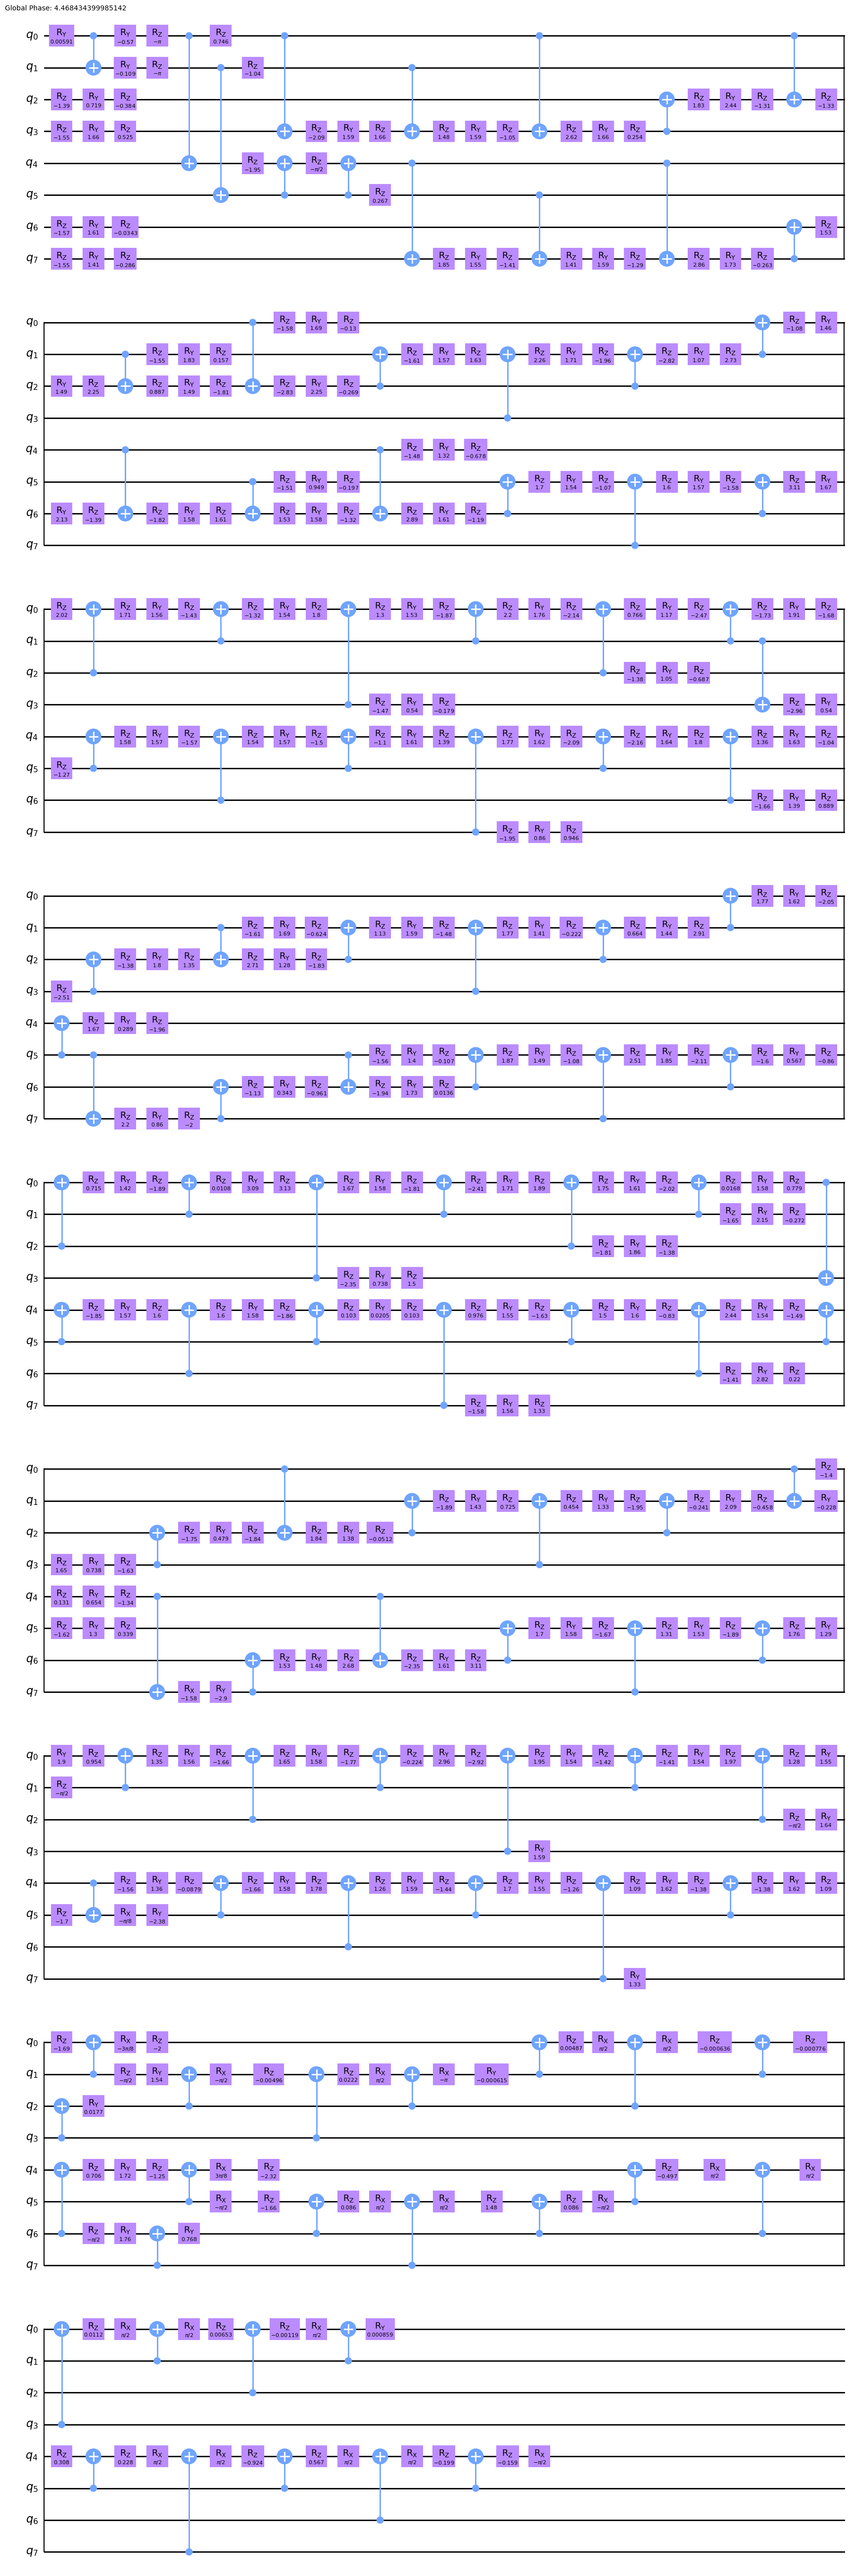

In [200]:
qc.draw('mpl')

In [ ]:
from qiskit.quantum_info import Statevector
print('state prepared by Q-alchemy',Statevector(qc).data.real)